# Лабораторная 4. Метод k-ближайших соседей

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

## Загружаем данные

In [2]:
data = pd.read_csv('data/WineDataset.csv')

## 1. Предварительная обработка данных

### Проверим на пропуски

In [3]:
data.isnull().sum()

Alcohol                         0
Malic Acid                      0
Ash                             0
Alcalinity of ash               0
Magnesium                       0
Total phenols                   0
Flavanoids                      0
Nonflavanoid phenols            0
Proanthocyanins                 0
Color intensity                 0
Hue                             0
OD280/OD315 of diluted wines    0
Proline                         0
Wine                            0
dtype: int64

### Если есть пропуски, можно заменить их средним значением

In [4]:
data.fillna(data.mean(), inplace=True)

### Проверим категориальные переменные

In [5]:
data.dtypes

Alcohol                         float64
Malic Acid                      float64
Ash                             float64
Alcalinity of ash               float64
Magnesium                       float64
Total phenols                   float64
Flavanoids                      float64
Nonflavanoid phenols            float64
Proanthocyanins                 float64
Color intensity                 float64
Hue                             float64
OD280/OD315 of diluted wines    float64
Proline                         float64
Wine                              int64
dtype: object

### Преобразуем целевой признак в категориальную переменную

In [6]:
data['Wine'] = data['Wine'].astype('category')

## 2. Масштабирование числовых признаков

In [7]:
scaler = StandardScaler()
X = data.drop(columns=['Wine'])
y = data['Wine']
X_scaled = scaler.fit_transform(X)

## 3. Визуализация статистики

### Статистика по датасету

In [8]:
data.describe()

,Alcohol,Malic Acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


### Визуализация статистики в виде тепловой карты

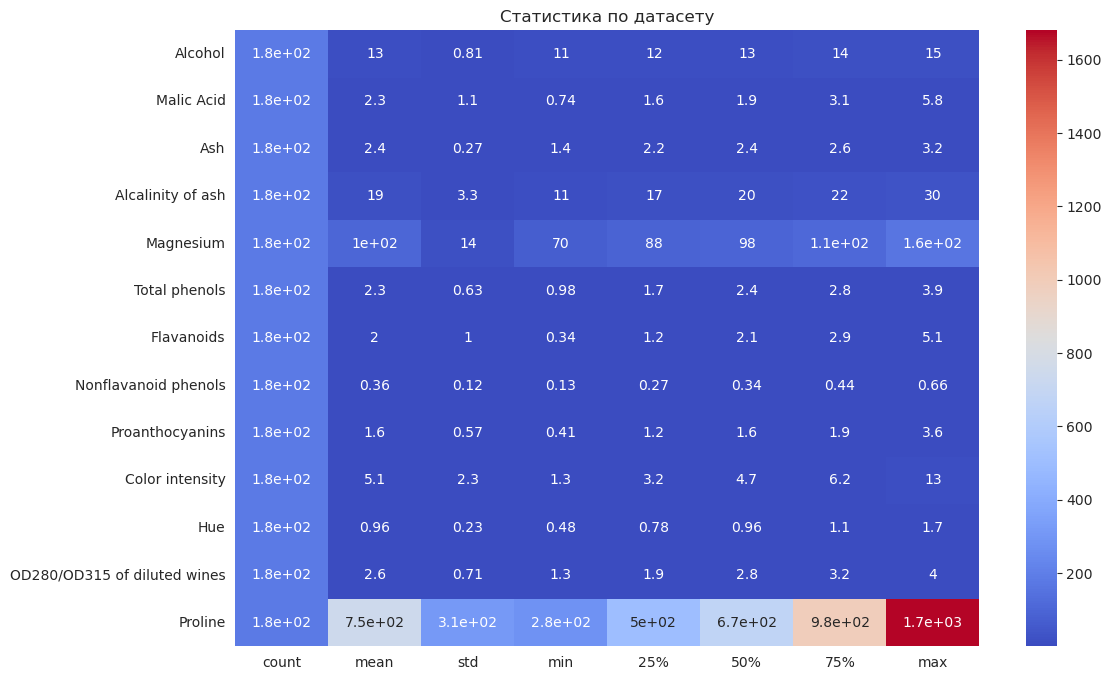

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.describe().T, annot=True, cmap='coolwarm')
plt.title("Статистика по датасету")
plt.show()

## 4. Построение 3D визуализации

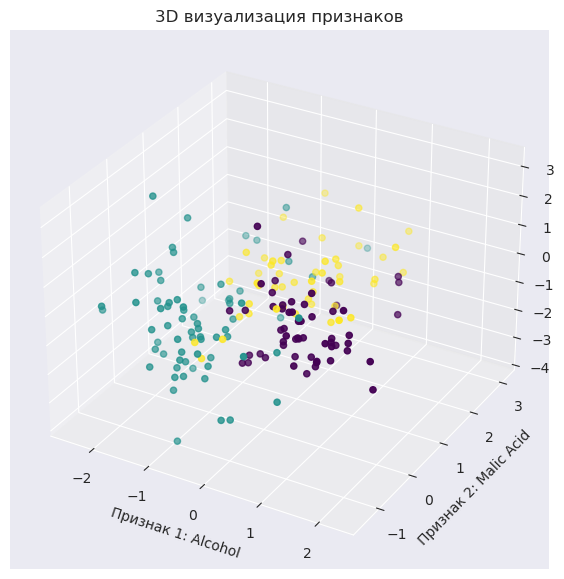

In [10]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=y, cmap='viridis')
ax.set_xlabel('Признак 1: Alcohol')
ax.set_ylabel('Признак 2: Malic Acid')
ax.set_zlabel('Признак 3: Ash')
plt.title("3D визуализация признаков")
plt.show()

## 5. Реализация метода K-ближайших соседей (KNN) без использования сторонних библиотек

In [11]:
'''
    Принцип работы KNN
    Алгоритм строится следующим образом:
    
    1) сначала вычисляется расстояние между тестовым и всеми обучающими образцами;

    2) далее из них выбирается k-ближайших образцов (соседей), где число k задаётся заранее;

    3) итоговым прогнозом среди выбранных k-ближайших образцов будет мода в случае классификации и среднее арифметическое в случае регрессии;

    4) предыдущие шаги повторяются для всех тестовых образцов.
'''

def knn(X_train, y_train, X_test, k):
    # Преобразуем категориальные столбцы в числовые (если такие есть)
    if isinstance(X_train, pd.DataFrame):
        X_train = pd.get_dummies(X_train)  # Преобразуем категориальные столбцы в числовые
        X_test = pd.get_dummies(X_test)

    # Преобразуем метки в числовые значения, если они категориальные
    if isinstance(y_train, pd.Series) and y_train.dtype.name == 'category':
        y_train = y_train.cat.codes  # Преобразуем категориальные метки в числовые

    # Вычисление расстояний между точками через евклидово расстояние
    # distances = np.linalg.norm(X_train - X_test, axis=1)  # Расстояния
    distances = []
    for train_point in X_train:
        # Вычисляем сумму квадратов разностей по каждому признаку
        distance = sum((train_point[i] - X_test[i]) ** 2 for i in range(len(X_test)))
        # Берем квадратный корень для получения Евклидова расстояния
        distance = distance ** 0.5
        distances.append(distance)

    sorted_indices = np.argsort(distances)                # Индексы ближайших соседей
    nearest_labels = y_train.iloc[sorted_indices[:k]]     # Метки ближайших соседей
    most_common = nearest_labels.mode()[0]                # Наиболее частая метка
    return most_common

## 6. Разбиение данных на обучающую и тестовую выборки

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

## 7. Модели K-NN с различными наборами признаков

### Модель 1: случайный отбор признаков

In [13]:
np.random.seed(42)
random_features = np.random.choice(X_train.shape[1], size=5, replace=False)
X_train_random = X_train[:, random_features]
X_test_random = X_test[:, random_features]

### Модель 2: фиксированный набор признаков

In [14]:
X_train_fixed = X_train[:, :3]  # Используем первые 3 признака
X_test_fixed = X_test[:, :3]

### Функция для тестирования моделей с разными значениями k

In [15]:
def evaluate_knn(X_train, y_train, X_test, y_test, k_values):
    accuracies = []
    for k in k_values:
        # Используем индексацию для ndarray
        predictions = [knn(X_train, y_train, X_test[i], k) for i in range(X_test.shape[0])]
        # Вычисляем точность
        accuracy = np.mean(np.array(predictions) == y_test)
        # Добавляем в список результатов
        accuracies.append(accuracy)
    return accuracies

### Проверим различные значения k для обеих моделей

In [16]:
k_values = [3, 5, 10]
accuracies_random = evaluate_knn(X_train_random, y_train, X_test_random, y_test, k_values)
accuracies_fixed = evaluate_knn(X_train_fixed, y_train, X_test_fixed, y_test, k_values)

### Визуализируем точность для разных значений k

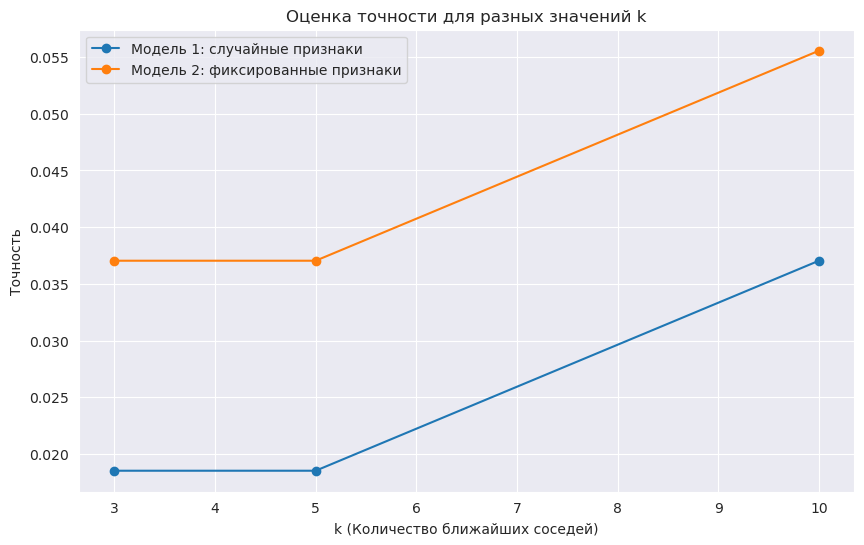

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies_random, label='Модель 1: случайные признаки', marker='o')
plt.plot(k_values, accuracies_fixed, label='Модель 2: фиксированные признаки', marker='o')
plt.xlabel('k (Количество ближайших соседей)')
plt.ylabel('Точность')
plt.title('Оценка точности для разных значений k')
plt.legend()
plt.show()

## 8. Построим матрицу ошибок для каждой модели при k=5

In [18]:
def confusion_matrix_knn(X_train, y_train, X_test, y_test, k):
    predictions = [knn(X_train, y_train, X_test[i], k) for i in range(X_test.shape[0])]
    cm = confusion_matrix(y_test, predictions)
    return cm

### Визуализируем матрицу ошибок

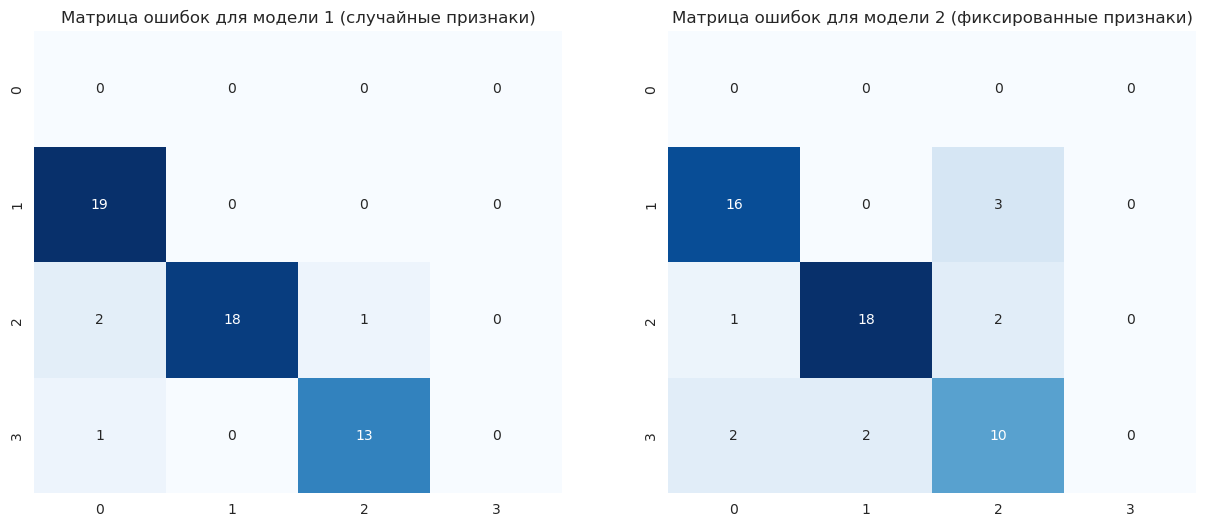

In [19]:
cm_random = confusion_matrix_knn(X_train_random, y_train, X_test_random, y_test, k=5)
cm_fixed = confusion_matrix_knn(X_train_fixed, y_train, X_test_fixed, y_test, k=5)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(cm_random, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Матрица ошибок для модели 1 (случайные признаки)')
sns.heatmap(cm_fixed, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False)
axes[1].set_title('Матрица ошибок для модели 2 (фиксированные признаки)')
plt.show()